# Import data

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from joblib import Parallel, delayed
import warnings
import lightgbm as lgb
from tqdm import tqdm
import re

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.multioutput import ClassifierChain
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

2025-11-20 17:31:01.343706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763659861.626148      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763659861.701562      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
data_path = '/kaggle/input/cs313-compound-data/df_final_1133.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
df

,CID,Molecular Weight,Hydrogen Bond Donor Count,Hydrogen Bond Acceptor Count,Rotatable Bond Count,Topological Polar Surface Area,Formal Charge,Complexity,Defined Atom Stereocenter Count,Undefined Atom Stereocenter Count,...,Manufacturing Components_y,antioxidant_y,cleaning_y,hair care_y,humectant_y,personal care_y,emulsifier_y,Surface/hysical Modifiers_y,oral care_y,preservative_y
0,66133,227.77,0,1,5,0.0,0,135.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,163336,170.29,1,1,6,20.2,0,127.0,0,1,...,0,0,1,0,0,1,0,0,0,0
2,519793,120.22,1,2,4,45.5,0,31.3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,82172,390.38,1,7,11,103.0,0,414.0,0,1,...,0,0,1,1,0,0,0,0,0,0
4,11229094,176.25,2,3,8,49.7,0,85.8,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9814,8892,116.16,1,2,4,37.3,0,68.9,0,0,...,0,0,1,0,0,0,1,0,0,0
9815,108764,170.23,0,3,2,55.5,0,158.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9816,5462986,126.20,0,1,3,17.1,0,112.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9817,24826,399.90,0,12,0,266.0,0,62.2,0,0,...,0,0,0,0,1,0,0,0,0,0


In [5]:
df = df.drop(columns=['cosmetics_y'])

In [6]:
df = df.rename(columns={'Art/Office/Toys': 'Art/Office/Toys_y'})

In [7]:
label_cols = [c for c in df.columns if c.endswith("_y")]
feature_cols = [c for c in df.columns if c not in label_cols]

X = df[feature_cols]
Y = df[label_cols]

In [8]:
len(feature_cols)

1076

In [9]:
len(label_cols)

56

In [10]:
# Sanitize tên cột cho LightGBM (xóa ký tự đặc biệt)
X.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X.columns]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (7855, 1076)
Test shape: (1964, 1076)


In [11]:
label_freq = df[label_cols].sum().sort_values()
label_freq.head(20)

reducing_y                                               62
dehydrating agent_y                                      63
Consumer Goods_y                                         67
hydrotrope_y                                             68
deodorant_y                                              76
Pest/Degradate_y                                         77
opacifier_y                                              78
Manufacturing Components_y                               86
cons. electronics, mech. appliances, and machinery_y     92
uv_y                                                     96
film forming_y                                          105
fungicide_y                                             106
batteries_y                                             107
Surface/hysical Modifiers_y                             116
laboratory supplies_y                                   119
Impurity/By-product_y                                   130
pH control_y                            

In [12]:
%%capture
!pip install smote-variants


# Classifier Chains + LightGBM

In [45]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.multioutput import ClassifierChain


import lightgbm as lgb
from sklearn.multiclass import OneVsRestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# try MLSMOTE implementation
MLSMOTE_AVAILABLE = False
try:
    from mlsmote import MLSMOTE
    MLSMOTE_AVAILABLE = True
    print('mlsmote pip available')
except Exception:
    print('mlsmote pip NOT available - will attempt fallback or local implementation')

if not MLSMOTE_AVAILABLE:
    try:
        import urllib.request
        url = 'https://raw.githubusercontent.com/marco-willi/mlsmote/master/mlsmote.py'
        urllib.request.urlretrieve(url, 'mlsmote.py')
        from mlsmote import MLSMOTE
        MLSMOTE_AVAILABLE = True
        print('mlsmote loaded from GitHub')
    except Exception:
        MLSMOTE_AVAILABLE = False
        print('Could not load MLSMOTE from GitHub - using fallback synthetic generator')

mlsmote pip NOT available - will attempt fallback or local implementation
Could not load MLSMOTE from GitHub - using fallback synthetic generator


In [ ]:
def simple_ml_smote(X, Y, n_samples=1000, random_state=42):
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    new_X = np.zeros((n_samples, d))
    new_Y = np.zeros((n_samples, Y.shape[1]), dtype=int)
    for i in range(n_samples):
        a, b = rng.randint(0, n), rng.randint(0, n)
        lam = rng.rand()
        new_X[i] = X[a] + lam * (X[b] - X[a])
        new_Y[i] = ((Y[a] + Y[b]) >= 1).astype(int)
    return new_X, new_Y

In [ ]:
# optimal thresholds per-label using valid set
def find_optimal_thresholds(y_true, y_probs, thresholds=np.linspace(0.01,0.99,99)):
    n_labels = y_true.shape[1]
    best_thresh = np.full(n_labels, 0.5)
    best_scores = np.zeros(n_labels)
    for j in range(n_labels):
        best_t = 0.5
        best_s = -1.0
        for t in thresholds:
            p = (y_probs[:, j] >= t).astype(int)
            s = f1_score(y_true[:, j], p, zero_division=0)
            if s > best_s:
                best_s = s
                best_t = t
        best_thresh[j] = best_t
        best_scores[j] = best_s
    return best_thresh, best_scores

In [49]:
X_np = X.values
Y_np = Y.values

X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y_np, test_size=0.2, random_state=42, shuffle=True)
print('Train shape:', X_train.shape, Y_train.shape)
print('Test shape:', X_test.shape, Y_test.shape)

Train shape: (7855, 1076) (7855, 56)
Test shape: (1964, 1076) (1964, 56)


In [ ]:
# create synthetic samples equal to 0.5 * len(X_train)
n_new = int(0.5 * X_train.shape[0])
print('Will create', n_new, 'synthetic samples')

if MLSMOTE_AVAILABLE:
    print('Using MLSMOTE package')
    mls = MLSMOTE(random_state=42)
    X_res, Y_res = mls.fit_resample(X_train, Y_train)
    X_train_res, Y_train_res = X_res, Y_res
else:
    print('Using fallback simple_ml_smote')
    X_syn, Y_syn = simple_ml_smote(X_train, Y_train, n_samples=n_new, random_state=42)
    X_train_res = np.vstack([X_train, X_syn])
    Y_train_res = np.vstack([Y_train, Y_syn])

print('After resample train shape:', X_train_res.shape, Y_train_res.shape)

Will create 3927 synthetic samples
Using fallback simple_ml_smote
After resample train shape: (11782, 1076) (11782, 56)


In [51]:
# check freq change
orig_counts = Y_train.sum(axis=0)
new_counts = Y_train_res.sum(axis=0)
freq_df = pd.DataFrame({'orig': orig_counts, 'resampled': new_counts}, index=label_cols)
display(freq_df.sort_values('orig').head(10))
display(freq_df.sort_values('resampled').head(10))

,orig,resampled
dehydrating agent_y,46,104
reducing_y,53,115
hydrotrope_y,54,106
Consumer Goods_y,54,105
deodorant_y,58,125
opacifier_y,61,114
Pest/Degradate_y,65,116
Manufacturing Components_y,70,152
"cons. electronics, mech. appliances, and machinery_y",72,145
fungicide_y,76,139


,orig,resampled
dehydrating agent_y,46,104
Consumer Goods_y,54,105
hydrotrope_y,54,106
opacifier_y,61,114
reducing_y,53,115
Pest/Degradate_y,65,116
deodorant_y,58,125
fungicide_y,76,139
"cons. electronics, mech. appliances, and machinery_y",72,145
Manufacturing Components_y,70,152


In [ ]:
base_params = {
    'n_estimators':700,
    'learning_rate':0.03,
    'num_leaves':62,
    'subsample':0.85,
    'colsample_bytree':0.92,
    'min_child_samples':60,
    'objective':'binary',
    'class_weight':'balanced',
    'verbosity':-1
}

RUN_OPTUNA = True
if RUN_OPTUNA:
    import optuna
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 31, 128),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
            'objective':'binary', 'verbosity':-1
        }
        
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        idx = 0
        for tr_idx, val_idx in kf.split(X_train_res):
            Xtr, Xval = X_train_res[tr_idx], X_train_res[val_idx]
            Ytr, Yval = Y_train_res[tr_idx], Y_train_res[val_idx]
            model = OneVsRestClassifier(lgb.LGBMClassifier(**params))
            model.fit(Xtr, Ytr)
            prob = model.predict_proba(Xval)
            pred = (prob >= 0.5).astype(int)
            sc = f1_score(Yval, pred, average='micro', zero_division=0)
            scores.append(sc)
            idx += 1
        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    print('Best params:', study.best_params)
    # update base_params
    base_params.update(study.best_params)

print('Using params:', base_params)

[I 2025-11-20 17:35:55,256] A new study created in memory with name: no-name-b8b9ed49-cc6d-48f7-8388-5876ce368bbf
[I 2025-11-20 17:48:07,835] Trial 0 finished with value: 0.6004409845574515 and parameters: {'n_estimators': 400, 'learning_rate': 0.05626167205936871, 'num_leaves': 73, 'subsample': 0.7945466995762629, 'colsample_bytree': 0.5167192224422765, 'min_child_samples': 149}. Best is trial 0 with value: 0.6004409845574515.
[I 2025-11-20 18:27:28,907] Trial 1 finished with value: 0.611905778797803 and parameters: {'n_estimators': 1000, 'learning_rate': 0.023343279582703994, 'num_leaves': 110, 'subsample': 0.7709971685733257, 'colsample_bytree': 0.8646788492213293, 'min_child_samples': 120}. Best is trial 1 with value: 0.611905778797803.
[I 2025-11-20 18:38:05,991] Trial 2 finished with value: 0.578957078145854 and parameters: {'n_estimators': 200, 'learning_rate': 0.024594067714390364, 'num_leaves': 107, 'subsample': 0.7122106472600136, 'colsample_bytree': 0.9212607659518488, 'min_

Best params: {'n_estimators': 1000, 'learning_rate': 0.0958988848136795, 'num_leaves': 34, 'subsample': 0.7562130687539566, 'colsample_bytree': 0.7261604885137948, 'min_child_samples': 53}
Using params: {'n_estimators': 1000, 'learning_rate': 0.0958988848136795, 'num_leaves': 34, 'subsample': 0.7562130687539566, 'colsample_bytree': 0.7261604885137948, 'min_child_samples': 53, 'objective': 'binary', 'class_weight': 'balanced', 'verbosity': -1}


In [ ]:
# Train ensemble Classifier Chains
N_CHAINS = 5
chains = []
print('Training', N_CHAINS, 'chains...')
for i in range(N_CHAINS):
    base_clf = lgb.LGBMClassifier(**base_params)
    chain = ClassifierChain(base_clf, order='random', random_state=42 + i)
    chain.fit(X_train_res, Y_train_res)
    chains.append(chain)
    print('Trained chain', i+1)


Training 5 chains...
Trained chain 1
Trained chain 2
Trained chain 3
Trained chain 4
Trained chain 5


In [ ]:
# predict probabilities by averaging chain
probs_list = []
for chain in chains:
    prob = chain.predict_proba(X_test)
    # convert to array
    if isinstance(prob, list):
        prob = np.vstack([p[:,1] if p.shape[1]>1 else p.ravel() for p in prob]).T
    probs_list.append(prob)

probs_chain = np.mean(np.array(probs_list), axis=0)
print('probs_chain shape', probs_chain.shape)

probs_chain shape (1964, 56)


In [55]:
# default threshold 0.5
pred_default = (probs_chain >= 0.5).astype(int)
print('Default thresholds - evaluation')
print('Micro F1:', f1_score(Y_test, pred_default, average='micro', zero_division=0))
print('Macro F1:', f1_score(Y_test, pred_default, average='macro', zero_division=0))
print('Weighted F1:', f1_score(Y_test, pred_default, average='weighted', zero_division=0))
print('ROC AUC (macro):', roc_auc_score(Y_test, probs_chain, average='macro'))

Default thresholds - evaluation
Micro F1: 0.6326219512195123
Macro F1: 0.4708451941642764
Weighted F1: 0.6140480839945623
ROC AUC (macro): 0.9141953413577111


In [ ]:
X_tr2, X_val2, Y_tr2, Y_val2 = train_test_split(X_train_res, Y_train_res, test_size=0.15, random_state=42)
chains_local = []
for i in range(3):
    base_clf = lgb.LGBMClassifier(**base_params)
    chain = ClassifierChain(base_clf, order='random', random_state=100+i)
    chain.fit(X_tr2, Y_tr2)
    chains_local.append(chain)

probs_val_list = []
for chain in chains_local:
    prob = chain.predict_proba(X_val2)
    if isinstance(prob, list):
        prob = np.vstack([p[:,1] if p.shape[1]>1 else p.ravel() for p in prob]).T
    probs_val_list.append(prob)
probs_val = np.mean(probs_val_list, axis=0)

In [ ]:
# optimal thresholds
thresholds, best_f1s = find_optimal_thresholds(Y_val2, probs_val, thresholds=np.linspace(0.01,0.99,99))
print('Sample thresholds (first 10):', thresholds[:10])

Sample thresholds (first 10): [0.02 0.34 0.03 0.12 0.05 0.01 0.48 0.01 0.39 0.01]


In [58]:
# apply thresholds to test
pred_opt = (probs_chain >= thresholds.reshape(1,-1)).astype(int)
print('Optimized thresholds - evaluation')
print('Micro F1:', f1_score(Y_test, pred_opt, average='micro', zero_division=0))
print('Macro F1:', f1_score(Y_test, pred_opt, average='macro', zero_division=0))
print('Weighted F1:', f1_score(Y_test, pred_opt, average='weighted', zero_division=0))

Optimized thresholds - evaluation
Micro F1: 0.6259024283526581
Macro F1: 0.5051407591201814
Weighted F1: 0.6305621088518558


In [ ]:
print("ROC AUC (macro) :", roc_auc_score(Y_test, probs_chain, average="macro"))
print(classification_report(Y_test, pred_opt, target_names=label_cols)) 

ROC AUC (macro) : 0.9141953413577111
                                                      precision    recall  f1-score   support

                                           biocide_y       0.51      0.65      0.57       108
                                         emollient_y       0.68      0.74      0.71       110
               construction and building materials_y       0.40      0.42      0.41        67
                                               dye_y       0.56      0.59      0.57        46
                         furniture and furnishings_y       0.26      0.33      0.29        27
                               laboratory supplies_y       0.29      0.32      0.30        22
                                         batteries_y       0.55      0.35      0.43        17
                                         fungicide_y       0.77      0.67      0.71        30
cons. electronics, mech. appliances, and machinery_y       0.64      0.35      0.45        20
                      

In [ ]:
from sklearn.metrics import hamming_loss

# ---- Hamming ----
hl = hamming_loss(Y_test, pred_opt)
print("Hamming Loss:", hl)
print("Hamming Accuracy:", 1 - hl)

print(classification_report(Y_test, pred_opt, target_names=label_cols))

Hamming Loss: 0.031095432062845506
Hamming Accuracy: 0.9689045679371545
                                                      precision    recall  f1-score   support

                                           biocide_y       0.51      0.65      0.57       108
                                         emollient_y       0.68      0.74      0.71       110
               construction and building materials_y       0.40      0.42      0.41        67
                                               dye_y       0.56      0.59      0.57        46
                         furniture and furnishings_y       0.26      0.33      0.29        27
                               laboratory supplies_y       0.29      0.32      0.30        22
                                         batteries_y       0.55      0.35      0.43        17
                                         fungicide_y       0.77      0.67      0.71        30
cons. electronics, mech. appliances, and machinery_y       0.64      0.35      0.

In [ ]:
labels = label_cols
f1_before = [f1_score(Y_test[:,j], pred_default[:,j], zero_division=0) for j in range(Y_test.shape[1])]
f1_after = [f1_score(Y_test[:,j], pred_opt[:,j], zero_division=0) for j in range(Y_test.shape[1])]

report_df = pd.DataFrame({'label': labels, 'f1_before': f1_before, 'f1_after': f1_after, 'threshold': thresholds})
report_df = report_df.sort_values('f1_after')

print('Top improved labels (after - before):')
report_df['delta'] = report_df['f1_after'] - report_df['f1_before']
print(report_df.sort_values('delta', ascending=False).head(20))


Top improved labels (after - before):
                                                label  f1_before  f1_after  \
35                                         reducing_y   0.333333  0.666667   
40                 oxidants and oxidant stabilizers_y   0.315789  0.486486   
30                                         additive_y   0.347826  0.517241   
41                                   Consumer Goods_y   0.315789  0.428571   
55                                     preservative_y   0.492754  0.595238   
7                                         fungicide_y   0.612245  0.714286   
42                                  processing aids_y   0.461538  0.543210   
33                                          foaming_y   0.678571  0.754098   
4                         furniture and furnishings_y   0.216216  0.290323   
36                                   Pest/Degradate_y   0.526316  0.600000   
9                                  home maintenance_y   0.502463  0.576052   
2               constructi

In [61]:
# show sample
display(report_df.head(30))

,label,f1_before,f1_after,threshold,delta
27,opacifier_y,0.153846,0.148148,0.31,-0.005698
26,deodorant_y,0.105263,0.160000,0.04,0.054737
11,dehydrating agent_y,0.210526,0.260870,0.02,0.050343
4,furniture and furnishings_y,0.216216,0.290323,0.05,0.074106
46,Manufacturing Components_y,0.307692,0.300000,0.01,-0.007692
32,antimicrobial_y,0.294118,0.303030,0.01,0.008913
5,laboratory supplies_y,0.258065,0.304348,0.01,0.046283
54,oral care_y,0.333333,0.326531,0.04,-0.006803
43,Impurity/By-product_y,0.409091,0.358209,0.01,-0.050882
29,unknown_y,0.314050,0.360360,0.01,0.046311


In [ ]:
joblib.dump(chains, 'chains_ensemble.pkl')
np.save('thresholds.npy', thresholds)
print('Saved ensemble and thresholds')

Saved ensemble and thresholds


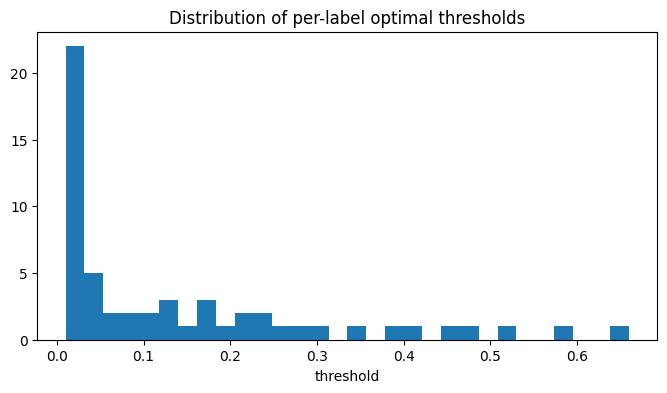

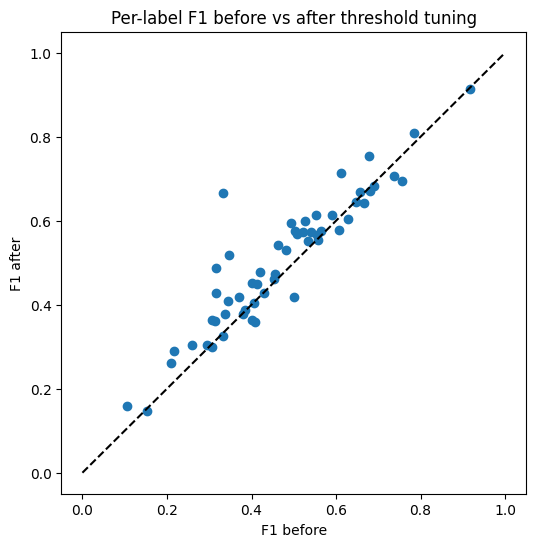

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(thresholds, bins=30)
plt.title('Distribution of per-label optimal thresholds')
plt.xlabel('threshold')
plt.show()

# plot before/after f1 scatter
plt.figure(figsize=(6,6))
plt.scatter(report_df['f1_before'], report_df['f1_after'])
plt.plot([0,1],[0,1],'k--')
plt.xlabel('F1 before')
plt.ylabel('F1 after')
plt.title('Per-label F1 before vs after threshold tuning')
plt.show()

